# Pytorch Fun!

In [63]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn as nn
import torch
import torch.utils as vutils

Let's use CIFAR 10 for fun!!!

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms =  transforms.Compose([
        transforms.RandomSizedCrop(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


image_dataset = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=data_transforms)
dataloders = torch.utils.data.DataLoader(image_dataset,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=4)


use_gpu = torch.cuda.is_available()

Files already downloaded and verified


Defining a simple CNN for CIFAR

In [10]:
class ConvNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 64 * 4 * 4)
        x = self.classifier(x)
        return x

model = ConvNet(num_classes=10)

model.features = torch.nn.DataParallel(model.features)
model.classifier = torch.nn.DataParallel(model.classifier)
model.cuda()

ConvNet (
  (features): DataParallel (
    (module): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU (inplace)
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (4): ReLU (inplace)
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU (inplace)
      (8): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (classifier): DataParallel (
    (module): Sequential (
      (0): Dropout (p = 0.5)
      (1): Linear (1024 -> 256)
      (2): ReLU (inplace)
      (3): Dropout (p = 0.5)
      (4): Linear (256 -> 256)
      (5): ReLU (inplace)
      (6): Linear (256 -> 10)
    )
  )
)

Defining the optimisation settings

In [12]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), 0.001,
                            momentum=False,
                            )

Prepare to monitor accuracy during training

In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

Let's train!!!

In [16]:
# switch to train mode
model.train()

for epoch in range(10):
    for i, (input, target) in enumerate(dataloders):

        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
    

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i%1000) == 0:
            print('Epoch: [[ {0} ]] [{1}/{2}]\t'.format(epoch, i, len(dataloders)))

Epoch: [[ 0 ]] [0/3125]	
Epoch: [[ 0 ]] [1000/3125]	
Epoch: [[ 0 ]] [2000/3125]	
Epoch: [[ 0 ]] [3000/3125]	
Epoch: [[ 1 ]] [0/3125]	
Epoch: [[ 1 ]] [1000/3125]	
Epoch: [[ 1 ]] [2000/3125]	
Epoch: [[ 1 ]] [3000/3125]	
Epoch: [[ 2 ]] [0/3125]	
Epoch: [[ 2 ]] [1000/3125]	
Epoch: [[ 2 ]] [2000/3125]	
Epoch: [[ 2 ]] [3000/3125]	
Epoch: [[ 3 ]] [0/3125]	
Epoch: [[ 3 ]] [1000/3125]	
Epoch: [[ 3 ]] [2000/3125]	
Epoch: [[ 3 ]] [3000/3125]	
Epoch: [[ 4 ]] [0/3125]	
Epoch: [[ 4 ]] [1000/3125]	
Epoch: [[ 4 ]] [2000/3125]	
Epoch: [[ 4 ]] [3000/3125]	
Epoch: [[ 5 ]] [0/3125]	
Epoch: [[ 5 ]] [1000/3125]	
Epoch: [[ 5 ]] [2000/3125]	
Epoch: [[ 5 ]] [3000/3125]	
Epoch: [[ 6 ]] [0/3125]	
Epoch: [[ 6 ]] [1000/3125]	
Epoch: [[ 6 ]] [2000/3125]	
Epoch: [[ 6 ]] [3000/3125]	
Epoch: [[ 7 ]] [0/3125]	
Epoch: [[ 7 ]] [1000/3125]	
Epoch: [[ 7 ]] [2000/3125]	
Epoch: [[ 7 ]] [3000/3125]	
Epoch: [[ 8 ]] [0/3125]	
Epoch: [[ 8 ]] [1000/3125]	
Epoch: [[ 8 ]] [2000/3125]	
Epoch: [[ 8 ]] [3000/3125]	
Epoch: [[ 9 ]] [0/3

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
# switch to evaluate mode
model.eval()

losses = AverageMeter()
top1 = AverageMeter()
top5 = AverageMeter()


for i, (input, target) in enumerate(dataloders):
    target = target.cuda(async=True)
    input_var = torch.autograd.Variable(input, volatile=True)
    target_var = torch.autograd.Variable(target, volatile=True)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
    
    losses.update(loss.data[0], input.size(0))
    top1.update(prec1[0], input.size(0))
    top5.update(prec5[0], input.size(0))

    if i % 100 == 0:
        print('Test: [{0}/{1}]\t'.format(i, len(dataloders)))



Test: [0/3125]	
Test: [100/3125]	
Test: [200/3125]	
Test: [300/3125]	
Test: [400/3125]	
Test: [500/3125]	
Test: [600/3125]	
Test: [700/3125]	
Test: [800/3125]	
Test: [900/3125]	
Test: [1000/3125]	
Test: [1100/3125]	
Test: [1200/3125]	
Test: [1300/3125]	
Test: [1400/3125]	
Test: [1500/3125]	
Test: [1600/3125]	
Test: [1700/3125]	
Test: [1800/3125]	
Test: [1900/3125]	
Test: [2000/3125]	
Test: [2100/3125]	
Test: [2200/3125]	
Test: [2300/3125]	
Test: [2400/3125]	
Test: [2500/3125]	
Test: [2600/3125]	
Test: [2700/3125]	
Test: [2800/3125]	
Test: [2900/3125]	
Test: [3000/3125]	
Test: [3100/3125]	


In [23]:
print('[TEST] Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

[TEST] Prec@1 21.078 Prec@5 74.000


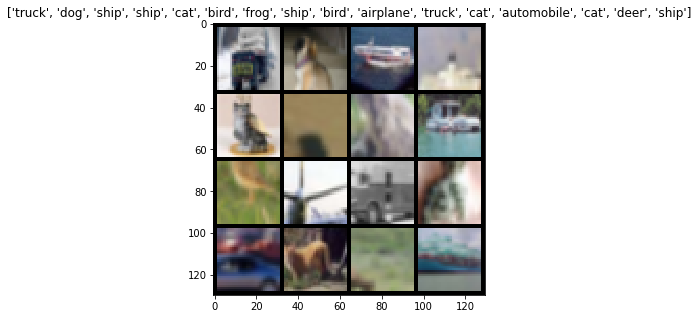

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(5,5))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

class_names = ['airplane','automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

imshow(out, title=[class_names[x] for x in classes])

In [61]:
from torch.autograd import Variable

def visualize_model(model, num_images=6):
    images_so_far = 0

    for i, data in enumerate(dataloders):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

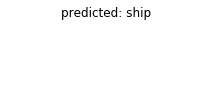

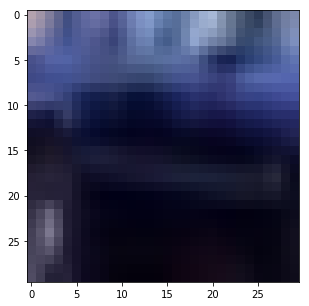

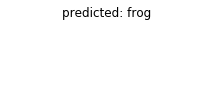

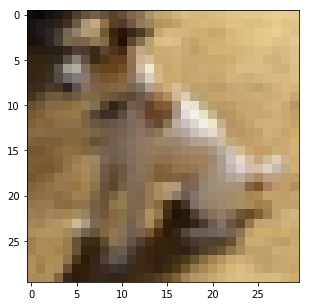

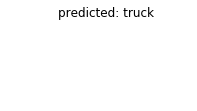

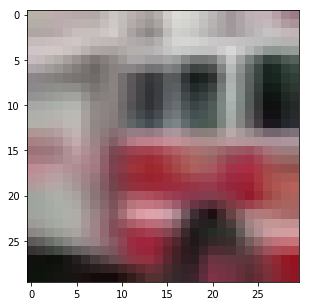

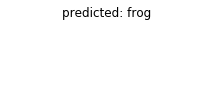

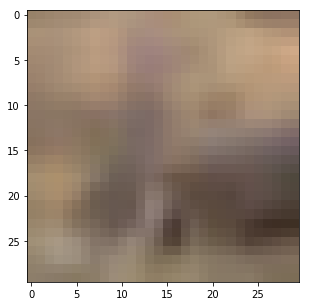

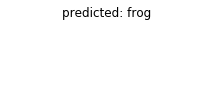

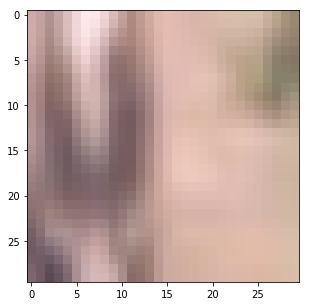

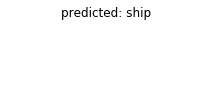

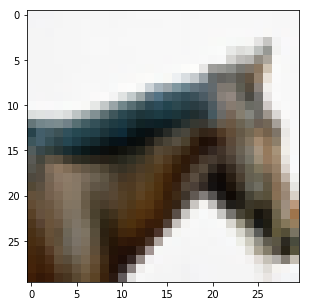

In [62]:
visualize_model(model)